In [1]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser

sys.path.append("../src")  # relative path from notebooks/ to src/
import JCM_models.xray_compounds as xc
import JCM_models.jcm_plotting_utils as JCMgrid
from JCM_models import Shape, ShapeGenerator, Source, Cartesian, PostProcess

#import geo_3 as geometry
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')


#jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
#jcm_root = join(home,'JCMwave/JCMsuite_6_4_8/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_6_4/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave

import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

#import xraylib

import time

import matplotlib as mpl
import matrixmethod as mm
mpl.rcParams['font.family'] = ['sans']
mpl.rcParams['font.serif'] = ['DejaVu Sans']
jcmwave.daemon.shutdown()

In [2]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
    Hostname="localhost",
    # Login='andrle01',
    Multiplicity=3,
    NThreads=12,
)

[877102708, 2106277339, 1119847577]

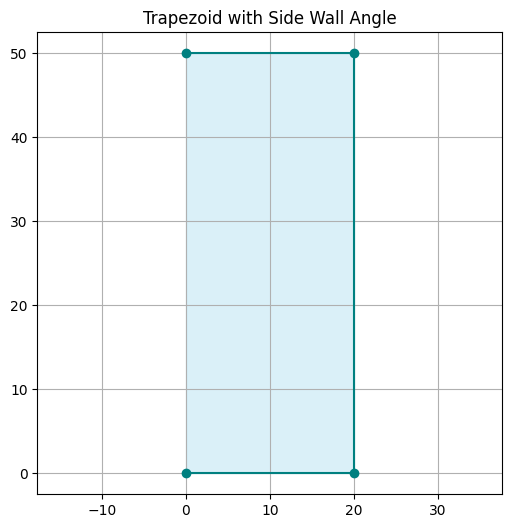

🔷 Shape: Rectangle
• Height: 50
• Width: 20
• Centered option available via `.centered()`


In [2]:


# Example usage
#params = {'height': [50,10], 'width': [20,10,20],'corner_radii': {3: 2.0, 2: 1.0}}
params = {'height': 50, 'width': 20}#,'corner_radii': {3: 2.0, 2: 1.0}}
#params = {'control_points':[(15,0),(10,10),(-10,10),(-10,0)]}
gen = ShapeGenerator('rectangle', params)

gen.plot(title="Trapezoid with Side Wall Angle")
print(gen.describe())

In [3]:

    
s_nm = Source(532, [1, 0], 45, 0, unit='nm')
s_eV = Source(2.33, [0, 1], 60, 90, unit='eV',incidence='FromBelow')

print(s_nm.describe())
print()
print(s_eV.describe())




🔆 Source description:
• Wavelength: 5.32e-07
• Polarization: [1, 0] → S-polarized
• Angle of incidence: 45°
• Azimuthal angle (phi): 0°
• Incidence direction: FromAbove
• Type: PlaneWave

🔆 Source description:
• Wavelength: 5.32121023318456e-07
• Polarization: [0, 1] → P-polarized
• Angle of incidence: 60°
• Azimuthal angle (phi): 90°
• Incidence direction: FromBelow
• Type: PlaneWave


In [4]:
thick = np.array([20,35,1.2] )
rough = np.array([0,0,0,0] )
wl = [13.5]
ang_deg = np.array([90])#np.linspace(0.1, 2.0, 10001)
ang = np.deg2rad(ang_deg)
nk_TOK = [1-0.023+0.00419j]
nk_Chaucer = [1-0.0226+0.0048j]
nk_SOG = [1-0.0195-0.006j]
nk_sub = np.conjugate(xc.refractive_index('Si',wl* unit.nm,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',wl* unit.nm,density=2.0929729034348785))

thick_noUL = np.array([20,1.2] )
rough_noUL = np.array([0,0,0] )
keys = {'uol1': 1e-9,
        'fem_deg': 4,}

#keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
#print(keys['energy'])
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lamb'] = wl[0] * 1e-9
keys['slc'] = 1


pitch = 50
substrate_offset = 30
vacuum_offset = 30
y = 60
slc = 1

computional_domain = ShapeGenerator('rectangle', {'height':y,'width':pitch},offset_y=-15).flatten(centered=True)
substrate = ShapeGenerator('rectangle', {'height':10,'width':pitch},offset_y=-10).flatten(centered=True)
substrate_oxide = ShapeGenerator('rectangle', {'height':2,'width':pitch}).flatten(centered=True)
bsplines = ShapeGenerator('bsplines', {'control_points':[(15,0),(10,10),(-10,10),(-10,0)]},offset_y=30).flatten(centered=True)
trapzoid_stack = ShapeGenerator('stack_trapezoids', {'height': [20,10], 'width': [20,10,20],'corner_radii': {3: 2.0, 2: 2.0}}).flatten(centered=True)

shape = [
    Shape('ComputationalDomain',domain_id = 1,priority=-1,side_length_constraint=slc,points=computional_domain, nk = 1,boundary = ['Transparent','Periodic','Transparent','Periodic'] ),
    Shape('substrate',domain_id = 2,priority=1,side_length_constraint=slc,points=substrate, nk = nk_sub ),
    Shape('substrate_oxide',domain_id = 3,priority=2,side_length_constraint=slc,points=substrate_oxide, nk = nk_sub_oxid ),
    #Shape('UL',domain_id = 4,priority=2,side_length_constraint=slc,points=bsplines, nk = nk_SOG ),
    Shape('resist',domain_id = 5,priority=2,side_length_constraint=slc,points=trapzoid_stack, nk = nk_TOK ),
]
shape[0].domain_id
keys['shape']=shape
keys['source']=[s_eV]
keys['energy_index'] = 0

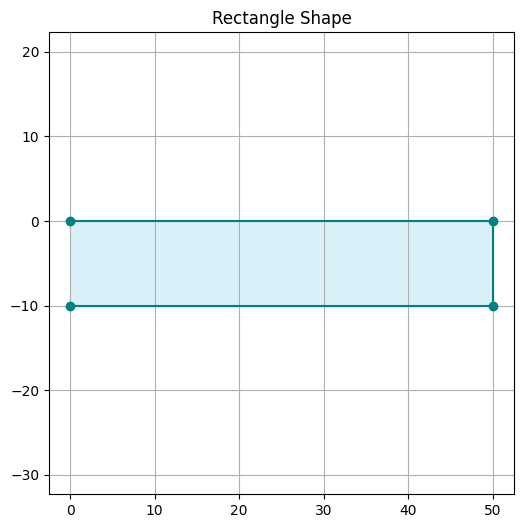

[-25.0, -10, 25.0, -10, 25.0, 0, -25.0, 0]

In [6]:
ShapeGenerator('rectangle', {'height':10,'width':pitch},offset_y=-10).plot()
substrate

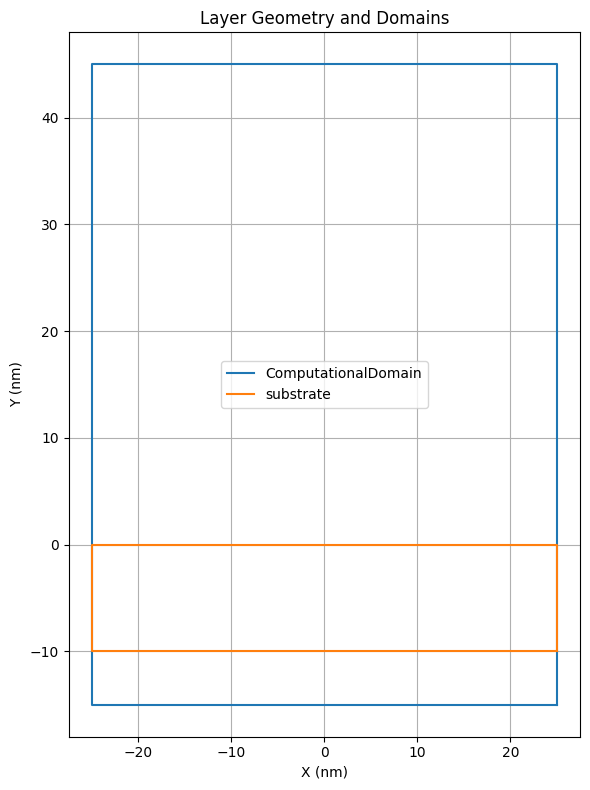

In [19]:
import matplotlib.pyplot as plt

# Create a shared figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each shape
for s in shape:
    s.plot(ax=ax)

# Final touches
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_title("Layer Geometry and Domains")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

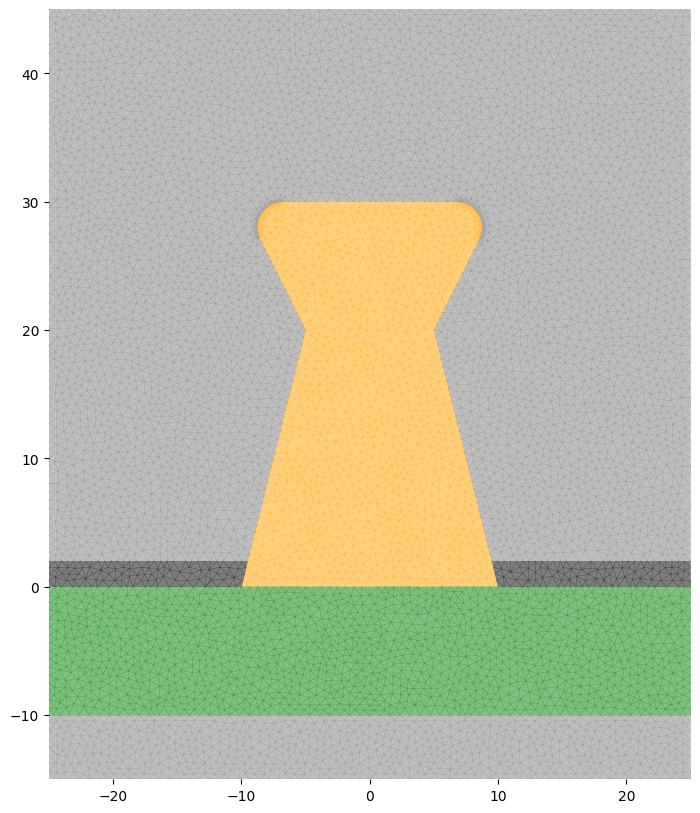

In [5]:
jcmwave.geo("../JCM_clean/",keys=keys)
fig, ax = plt.subplots(figsize=(10, 10))

JCMgrid.plot_grid(
    "../JCM_clean/grid.jcm",
    ax=ax,
    colors={1: "grey", 2: "green", 3: "black", 4: "blue", 5: "orange", 6: "pink"},
    alpha=0.5,
    lw=0.2,
)
ax.set_xlim(-pitch/2, pitch/2)
ax.set_ylim(-15, 45)
ax.set_frame_on(False)
# remove ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_aspect("equal")

In [10]:

    
cart = Cartesian(spacing=0.1e-9)
cart = Cartesian(n_grid_points_x=100,n_grid_points_y=100)
print(cart.to_jcm())

pp1 = PostProcess(
    mode="ExportFields",
    field_bag_path="project_results/fieldbag.jcm",
    output_file_name="project_results/fieldbag_near_field_xy.jcm",
    output_quantity="ElectricFieldStrength", #"ElectricFieldEnergyDensity"# "ElectricFieldStrength"
    cartesian=cart
)

pp2 = PostProcess(
    mode="FourierTransform",
    field_bag_path="project_results/fieldbag.jcm",
    output_file_name="project_results/ft.jcm",
    normal_direction="Y"
)

print(pp1.to_jcm())
print()
print(pp2.to_jcm())


  Cartesian {
    NGridPointsX = 100
    NGridPointsY = 100
  }
PostProcess {
  ExportFields {
    FieldBagPath = "project_results/fieldbag.jcm"
    OutputFileName = "project_results/fieldbag_near_field_xy.jcm"
    OutputQuantity = "ElectricFieldStrength"
    Cartesian {
      NGridPointsX = 100
      NGridPointsY = 100
    }
  }
}

PostProcess {
  FourierTransform {
    FieldBagPath = "project_results/fieldbag.jcm"
    OutputFileName = "project_results/ft.jcm"
    NormalDirection = Y
  }
}


In [11]:
ids = []

keys['slc'] = 0.7

keys['phi']=90
keys['angle_of_incidence']= 0 #-82 #87.285796
keys['postprocess']=[pp1,pp2]
s_eV = Source(lam=200, polarization=[1, 0], angle_of_incidence=45, phi=45, unit='nm',incidence='FromBelow')
keys['source']=[s_eV]
results = jcmwave.solve("../JCM_clean/project.jcmpt",keys=keys)
#ids.append(
#    jcmwave.solve('../JCM_clean/project-field.jcmpt',  keys=keys, temporary=True)
#)
#results = [results]

#results, logs = jcmwave.daemon.wait(ids, verbose=False)




*** Solving /home/kas/Projects/JCMwave_modeling/JCM_clean/project.jcmp on refinement level 0 ... 
  *** A priori interior domain wave propagation characteristics (vacuum wavelength = 200.000 nm):
  
       Compartment "Y":
    computational domain size: 0.26 (wavelengths).
    computational domain range wave propagation error:    0
    'one wavelength' wave propagation error:    0 
  
       Compartment "-Y":
    computational domain size: 0.26 (wavelengths).
    computational domain range wave propagation error:    0
    'one wavelength' wave propagation error:    0 

Cell percentage per Finite Element degree
  FEM degree  Cell percentage
-----------------------------------------
           4            100.0

assembling problem (1006745 unknowns) ...  
assembling problem done: 00:01:26.73 (cpu), 00:01:34.22 (total) (matrix entries/row = 43)
solving discrete problem ... 
Memory requirement estimated by the linear system solver: 2.96GB
estimated remaining time [step]: 00:01:30[25], 

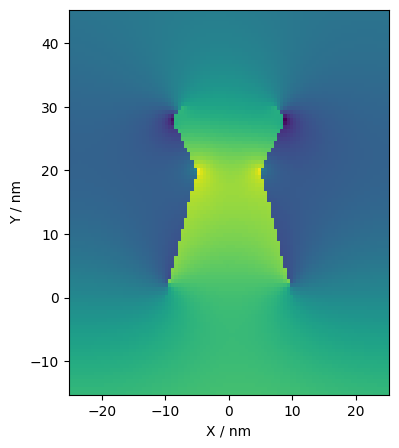

In [9]:
#jcmwave.view('./_JCMupdate/project_results/fieldbag.jcm')
result = results#[0] #job_ids#[-1]
index_take = 1
amplitude = result[index_take]['field'][0]
intensity = (amplitude.conj()*amplitude).sum(2).real 


#intensity = np.absolute(result[4]['field'][0])

#np.shape(result[4]['X'])
np.shape(intensity)
#intensity
figure,ax1 =plt.subplots(1,1, figsize=(8,5))
plt.pcolormesh(result[index_take]['X']*1e9,result[index_take]['Y']*1e9,np.log(intensity))#, vmax=3.18e-23)
#plt.pcolormesh(result[index_take]['X']*1e9+keys['pitch'],result[index_take]['Y']*1e9,(intensity))#, vmax=3.18e-23)

plt.xlabel('X / nm')
plt.ylabel('Y / nm')
ax1.set_aspect('equal')
#plt.colorbar(label='log(field intensity) / a.u.')



#plt.plot(x_oxide,y_oxide,'k-')
#plt.plot(x_mem,y_mem,'k-')
#figure.savefig('field_distribution_Ni_01.png',dpi=200)